In [162]:
# Load packages
import pandas as pd
import numpy as np
import time
import pytz
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for web scraping
import lxml.html as lx
import requests
import requests_cache
import newspaper
from newspaper import Article
from newspaper import news_pool

# Packages for nltk
import re
import nltk
from nltk.corpus import wordnet
from wordcloud import WordCloud, STOPWORDS

# Packages for nlp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Package for saving df as txt files
import pickle

plt.rcParams["figure.figsize"] = [10, 8]

In [135]:
# Test the newspaper function
link = "https://www.nytimes.com/2019/02/28/business/energy-environment/pge-camp-fire.html"
article = Article(link)
article.download()
article.parse()
article.text

'Pacific Gas & Electric said Thursday that its equipment had probably caused the Camp Fire, the catastrophic November blaze that destroyed thousands of homes in Paradise, Calif., and killed at least 86 people.\n\nPG&E, which filed for bankruptcy protection in January, said it had recorded a $10.5 billion charge in anticipation of damage claims for that fire, the deadliest in state history. Largely as a result, the company reported a $6.9 billion loss for 2018.\n\nThough the cause of the fire is still under official investigation by California officials, PG&E said it “believes it is probable that its equipment will be determined to be an ignition point of the 2018 Camp Fire.” Attempts to determine the fire’s cause center on the 56-mile Caribou-Palermo electric transmission line.\n\nThe California Department of Forestry and Fire Protection has said the fire started at 6:33 a.m. on Nov. 8 near a tower on that line. PG&E said that its line de-energized at 6:15 a.m., adding that 15 minutes 

In [136]:
# Get google news links for each search term
search_term_links = [
    "https://news.google.com/search?q=camp%20fire&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20death%20toll&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20california&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20paradise&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20map&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20news&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20cleanup&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20debris%20removal&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20pg&e&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20investigation&hl=en-US&gl=US&ceid=US%3Aen"
]

In [137]:
# Function that gets article links for each Google News search term
def get_links(url):
    """Gets the article links for one Chronicle article list. The parameter "url" is the url to the 
    article list."""
    
    response = requests.get(url)
    response.raise_for_status()
    html = lx.fromstring(response.text)
    html.make_links_absolute(url)
    
    links = html.xpath("//*[contains(@class, 'NiLAwe y6IFtc R7GTQ keNKEd j7vNaf nID9nc')]/a/@href")

    return links

In [139]:
# Get article links for each search term
l = [get_links(l) for l in search_term_links]

# Unlist the links and get the unique links
links = [item for sublist in l for item in sublist]
links = np.unique(links)

# Show the total number of articles we retrieved
len(links)

664

In [143]:
# Extract text and publish date for the urls

def get_article_info(link):
    """Extract the title, text, publish date from a news article. The parameter link is the article link.
    Returns a dictionary of title, text, publish date, and url."""
    
    # Do not get the images.
    article = Article(link, fetch_images = False)
    
    # Not all articles can be downloaded/parsed.
    try:
        article.download()
        article.parse()
        
        title = article.title
        text = article.text
        date = article.publish_date
    except:
        # If article can't be parsed, set the variables to None.
        title = None
        text = None
        date = None
    
    url = link
    
    res = {"url": url, 
           "title": title, 
           "text": text,
           "date": date}
    
    return res

In [149]:
# Extract article info. Returns a list of dictionaries. Each dictionary has the article data. 
# NOTE: This will take a long time (about 5 min).

article_list = [get_article_info(x) for x in links]

In [150]:
# Convert the article list to a dataframe
articles = pd.DataFrame(article_list)

# Remove articles where we could not extract the the text
articles = articles[~articles["text"].isna()]

# Convert the date column to datetime type
articles["date"] = pd.to_datetime(articles["date"], utc = True)

# Remove articles from paradise post (because this is from our local news source and we don't want overlap)
articles = articles[~articles["url"].str.contains("paradisepost")]

In [153]:
# Save the articles dataframe, so we don't have to scrape again.
# articles.to_pickle("articles.txt")

# NOTE: We deleted this file in git, so we are not able to read pickle. 
# We only kept the cleaned google news df (shown in the next cell below)
# articles = pd.read_pickle("articles.txt")
articles.head()

,date,text,title,url
1,2019-01-10 03:34:56+00:00,The state agency in charge of wildfire cleanup...,Suspect shipyard contractor gets huge state de...,https://news.google.com/articles/CAIiEA9Jb-O5w...
3,NaT,"(CNN) For nearly a month, Omar Franklin and hi...",Paradise residents are slowly returning home n...,https://news.google.com/articles/CAIiEADkXdc7r...
4,NaT,"As the Camp Fire raged, killing at least 85 pe...","After the deadly Camp Fire, a dog waited for h...",https://news.google.com/articles/CAIiEAIusDRPh...
5,NaT,A website and public Facebook group have recen...,Map shows where displaced Camp Fire wildfire s...,https://news.google.com/articles/CAIiEAMZa5R95...
6,NaT,More than 200 California students rallied Frid...,Students protest climate change at California ...,https://news.google.com/articles/CAIiEAWtaXWkc...


In [154]:
# Only keep the title and text in this dataframe so we can merge all three news sources.

# Clean up the articles data frame. This is commented out because we pickled it.
# articles_gn = articles.loc[:,['text', 'title']]
# articles_gn["title"] = articles_gn["title"].str.replace("\n","")
# articles_gn["source"] = "Google News"

# Save the dataframe
# articles_gn.to_pickle("articles_gn.txt")
articles_gn = pd.read_pickle("articles_gn.txt")
articles_gn.head()

,text,title,source
0,"California wildfires are raging this summer, b...",California Fires Map: Get the Latest Updates f...,Google News
1,"California wildfires are burning again, with t...","California Fires: Wildfires Map for Camp, Wool...",Google News
2,"Corrected, Dec. 12., 3:05p.m. ET\n\nFollowing ...",35 Paradise Families Sue PG&E Over California'...,Google News
3,It’s one thing to read about the massive devas...,Heartbreaking 360-Degree Film Shows Aftermath ...,Google News
4,PG&E is restructuring its board following the ...,PG&E Board of Directors Is Restructuring After...,Google News


In [155]:
def tokenize_text(df):
    """Combine the strings in the "text" column of dataframe df into one long string. Then, tokenize the
    string and make all words lowercase."""
    
    # Combine the "text" column into a string.
    doc = ' '.join(df['text'].tolist())

    # Tokenize and make lowercase.
    words = nltk.word_tokenize(doc)
    words = [w.lower() for w in words]
    
    return words

In [156]:
# I took this function from Nick's lecture 2/14. It is for lemmitization.
def wordnet_pos(tag):
    """Map a Brown POS tag to a WordNet POS tag."""
    
    table = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
    
    # Default to a noun.
    return table.get(tag[0], wordnet.NOUN)

In [157]:
def lemmatize_text(words):
    """Lemmatize words to get the base words. The input 'words' is a list of of words."""
    
    lemmatizer = nltk.WordNetLemmatizer()
    word_tags = nltk.pos_tag(words)
    words = [lemmatizer.lemmatize(w, wordnet_pos(t)) for (w, t) in word_tags]
    
    return words

In [158]:
def remove_stopwords(words):
    """Remove stopwords from a string."""
    
    stopwords = nltk.corpus.stopwords.words("english")
    words = [w for w in words if w not in stopwords]
    
    return words

In [160]:
# Tokenize, lemmatize, and remove stopwords for the text of all articles.
words = tokenize_text(articles_gn)
words = lemmatize_text(words)
words = remove_stopwords(words)
words = [w for w in words if w.isalnum()]

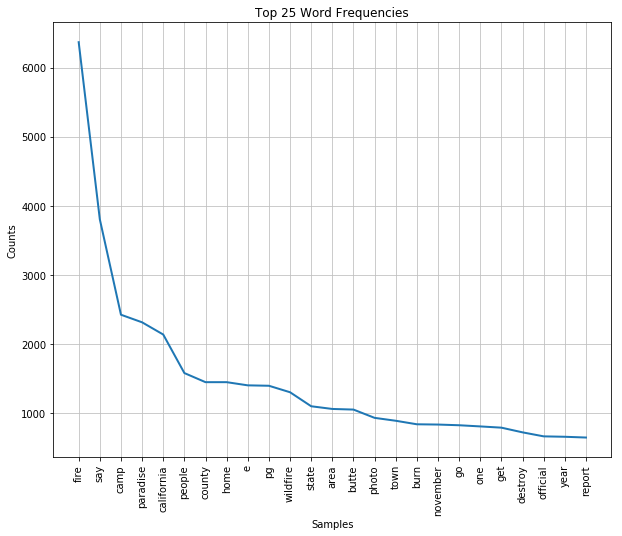

In [163]:
# Create a frequency plot.
fq = nltk.FreqDist(w for w in words if w.isalnum())
fq.plot(25, title = "Top 25 Word Frequencies")

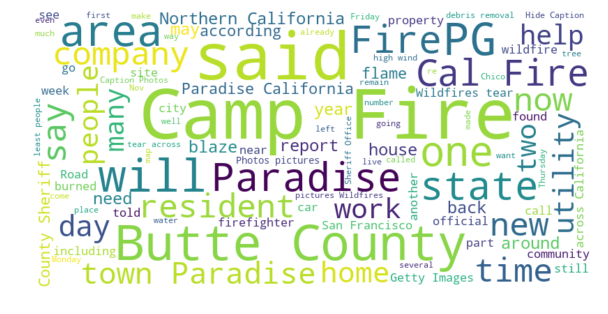

In [164]:
# Word cloud for articles we extracted from Google News.
doc = ' '.join(articles_gn['text'].tolist())
wordcloud = WordCloud(width = 800, 
                      height = 400, 
                      max_font_size = 100,
                      max_words = 100,
                     background_color = "white").generate(doc)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
# This function is for cleaning the text for tfidf.
# I adapted this function from http://brandonrose.org/clustering so that it lemmitizes the words as well.

def tokenize_and_lem(text):
    """Tokenizes and lemmatizes a string. The input is a single string. The output is a list of words that
    has been tokenized and lemmatized."""
    
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    
    lem = lemmatize_text(filtered_tokens)
    return lem


In [ ]:
# Generate the tfidf matrix for all google articles combined
text_list = articles_gn['text'].tolist()
vec = TfidfVectorizer(max_df = 0.8, min_df=0.2,
                      tokenizer = tokenize_and_lem, 
                      stop_words = "english", 
                      sublinear_tf = True)
tfidf = vec.fit_transform(text_list)

In [166]:
# Show tfidf dimensions
tfidf

<644x117 sparse matrix of type '<class 'numpy.float64'>'
	with 22840 stored elements in Compressed Sparse Row format>

In [ ]:
# Tfidf for bigrams for all google news articles
text_list = articles_gn['text'].tolist()
vec_bigram = TfidfVectorizer(min_df=0.1,
                      tokenizer = tokenize_and_lem, 
                      stop_words = "english", 
                      sublinear_tf = True,
                      ngram_range=(2,2))
tfidf_bigram = vec_bigram.fit_transform(text_list)

In [169]:
# Show some of the terms from the bigram tfidf
terms_bigram = vec_bigram.get_feature_names()
terms_bigram[:10]

['butte county',
 'california department',
 'california history',
 'california s',
 'california wildfire',
 'county sheriff',
 'deadly wildfire',
 'death toll',
 'debris removal',
 'destroy home']